In [3]:
!pip -q install /kaggle/input/pytorchtabnet/pytorch_tabnet-4.1.0-py3-none-any.whl

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'D:\\kaggle\\input\\pytorchtabnet\\pytorch_tabnet-4.1.0-py3-none-any.whl'


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Standard Libraries
import os
import re
import warnings
from concurrent.futures import ThreadPoolExecutor

# Data Handling and Processing
import numpy as np
import pandas as pd
import polars as pl  # Faster alternative to Pandas for large data
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline

# Machine Learning and Deep Learning Libraries
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor


# For TabNet
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from pytorch_tabnet.callbacks import Callback
import os
import torch
from pytorch_tabnet.callbacks import Callback
from pytorch_tabnet.tab_model import TabNetRegressor

# Optimization
from scipy.optimize import minimize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from tqdm import tqdm
from colorama import Fore, Style
from IPython.display import clear_output
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim



# Display settings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

# Define Severity Labels
severity_levels = ['None', 'Mild', 'Moderate', 'Severe']
season_enum = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

# Load and Preprocess Training Dataset
train_data = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_enum))  # Cast season-related columns to season_enum
)

# Load and Preprocess Test Dataset
test_data = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_enum))  # Cast season-related columns to season_enum
)

# Display a sample of loaded data for quick verification
print("Sample of Training Data:")
print(train_data.head())
print("\nSample of Test Data:")
print(test_data.head())


ModuleNotFoundError: No module named 'polars'

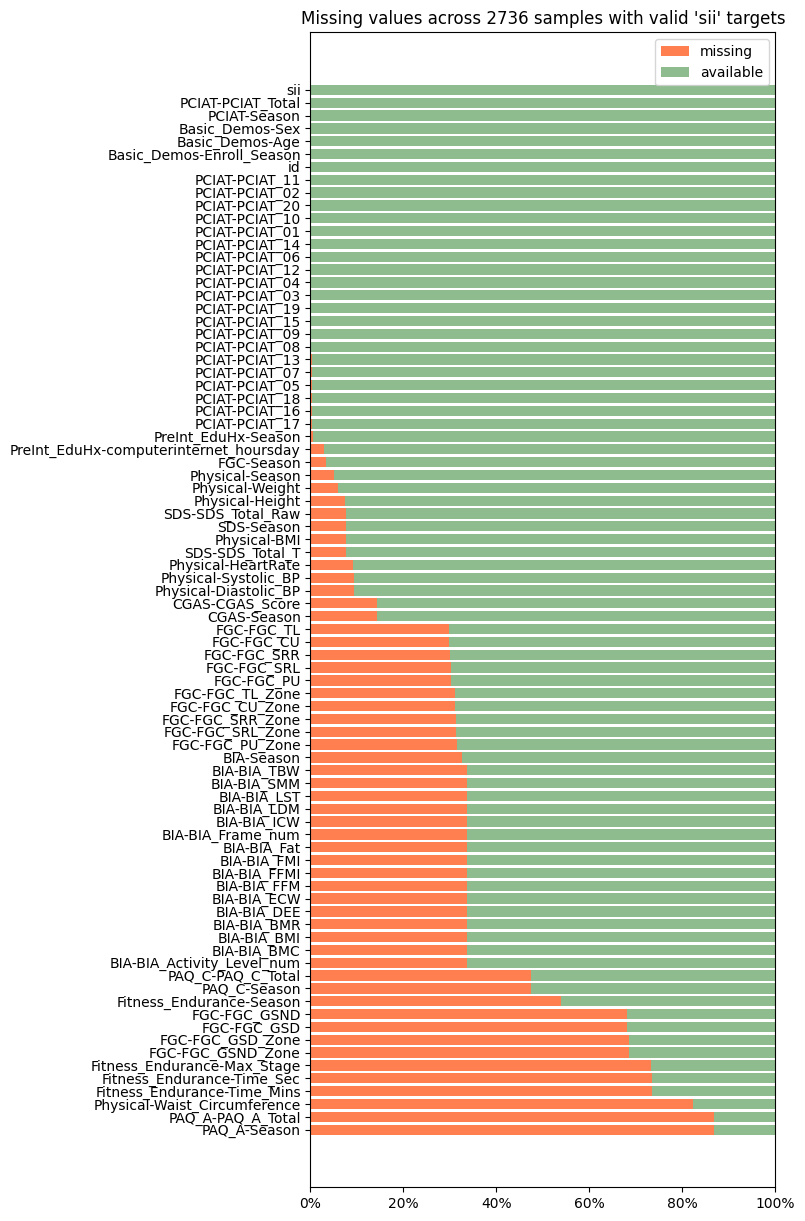

Percentage of consistent missing values between 'PCIAT-PCIAT_Total' and 'sii': 100.00%
Summary of 'PCIAT-PCIAT_Total' by 'sii' levels:
shape: (5, 4)
┌──────┬─────────────────┬─────────────────┬───────┐
│ sii  ┆ PCIAT_Total_min ┆ PCIAT_Total_max ┆ count │
│ ---  ┆ ---             ┆ ---             ┆ ---   │
│ i64  ┆ i64             ┆ i64             ┆ u32   │
╞══════╪═════════════════╪═════════════════╪═══════╡
│ null ┆ null            ┆ null            ┆ 1224  │
│ 0    ┆ 0               ┆ 30              ┆ 1594  │
│ 1    ┆ 31              ┆ 49              ┆ 730   │
│ 2    ┆ 50              ┆ 79              ┆ 378   │
│ 3    ┆ 80              ┆ 93              ┆ 34    │
└──────┴─────────────────┴─────────────────┴───────┘


In [45]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

# Step 1: Filter out rows with missing 'sii' values for supervised learning
filtered_data = train_data.filter(pl.col('sii').is_not_null())

# Step 2: Calculate missing values per feature
missing_values = (
    filtered_data
    .null_count()
    .transpose(include_header=True, header_name='feature', column_names=['missing_count'])
    .sort('missing_count', descending=True)
    .with_columns((pl.col('missing_count') / len(filtered_data)).alias('missing_ratio'))
)

# Step 3: Plot missing value ratios for features
plt.figure(figsize=(6, 15))
plt.title(f"Missing values across {len(filtered_data)} samples with valid 'sii' targets")

# Plot bars for missing and available values
plt.barh(np.arange(len(missing_values)), missing_values.get_column('missing_ratio'), color='coral', label='missing')
plt.barh(np.arange(len(missing_values)), 
         1 - missing_values.get_column('missing_ratio'),
         left=missing_values.get_column('missing_ratio'),
         color='darkseagreen', label='available')

# Customize plot appearance
plt.yticks(np.arange(len(missing_values)), missing_values.get_column('feature'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

# Step 4: Check if 'PCIAT-PCIAT_Total' missing values align with 'sii' missing values
pciat_sii_match_ratio = train_data.select((pl.col('PCIAT-PCIAT_Total').is_null() == pl.col('sii').is_null())).to_series().mean()
print(f"Percentage of consistent missing values between 'PCIAT-PCIAT_Total' and 'sii': {pciat_sii_match_ratio * 100:.2f}%")

# Step 5: Group by 'sii' to find min, max, and count of 'PCIAT-PCIAT_Total' within each 'sii' level
pciat_summary_by_sii = (
    train_data
    .select(pl.col('PCIAT-PCIAT_Total'))
    .group_by(train_data.get_column('sii'))
    .agg([
        pl.col('PCIAT-PCIAT_Total').min().alias('PCIAT_Total_min'),
        pl.col('PCIAT-PCIAT_Total').max().alias('PCIAT_Total_max'),
        pl.col('PCIAT-PCIAT_Total').len().alias('count')
    ])
    .sort('sii')
)

print("Summary of 'PCIAT-PCIAT_Total' by 'sii' levels:")
print(pciat_summary_by_sii)


In [46]:
# Checking Class Imbalance in the Target Variable
print("Note: This dataset is imbalanced, with a significant number of samples in class 0 and very few in class 3.")

# Identifying Columns Present in Training Data but Missing in Test Data
missing_in_test = [col for col in train_data.columns if col not in test_data.columns]
print("Columns present in training data but missing in test data:")
print(missing_in_test)


Note: This dataset is imbalanced, with a significant number of samples in class 0 and very few in class 3.
Columns present in training data but missing in test data:
['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


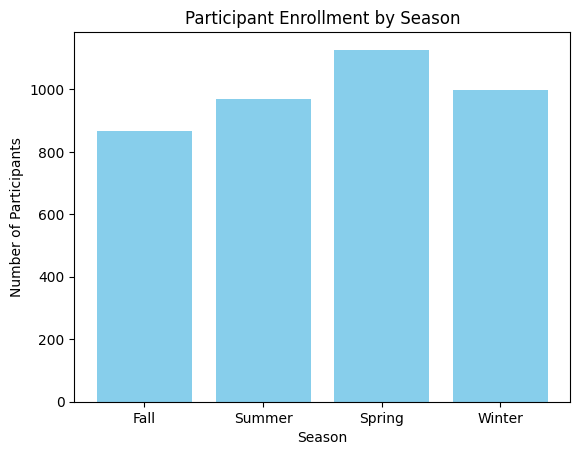

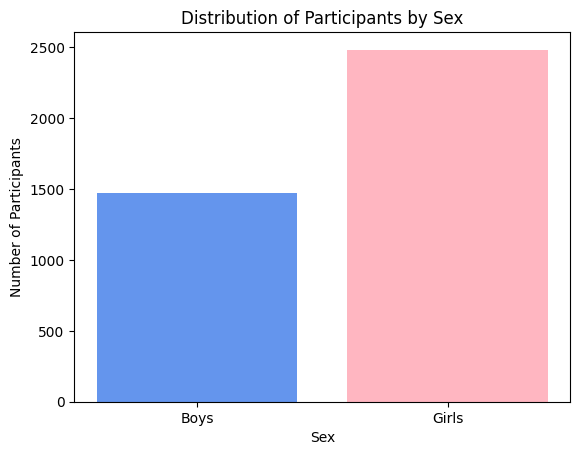

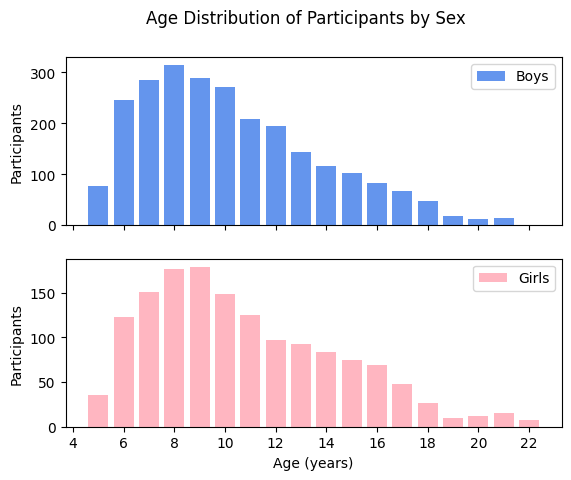

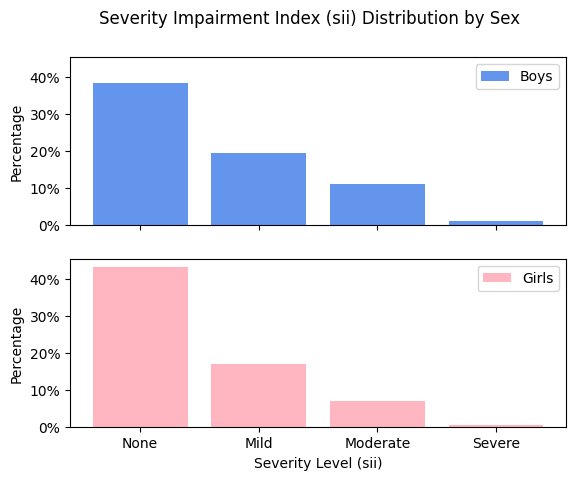

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter, MaxNLocator

# Plot Enrollment Season Distribution (using a bar chart for clearer comparison)
enroll_season_counts = train_data.get_column('Basic_Demos-Enroll_Season').value_counts()
plt.figure()
plt.bar(enroll_season_counts.get_column('Basic_Demos-Enroll_Season'), enroll_season_counts.get_column('count'), color='skyblue')
plt.title('Participant Enrollment by Season')
plt.xlabel('Season')
plt.ylabel('Number of Participants')
plt.show()

# Plot Sex Distribution of Participants (using a bar chart for clarity)
sex_counts = train_data.get_column('Basic_Demos-Sex').value_counts()
plt.figure()
plt.bar(['Boys', 'Girls'], sex_counts.get_column('count'), color=['cornflowerblue', 'lightpink'])
plt.title('Distribution of Participants by Sex')
plt.xlabel('Sex')
plt.ylabel('Number of Participants')
plt.show()

# Plot Age Distribution by Sex (using histograms for better age grouping)
fig, age_axes = plt.subplots(2, 1, sharex=True)
for gender in range(2):  # 0 for boys, 1 for girls
    ax = age_axes[gender]
    age_counts = train_data.filter(pl.col('Basic_Demos-Sex') == gender).get_column('Basic_Demos-Age').value_counts()
    ax.bar(age_counts.get_column('Basic_Demos-Age'),
           age_counts.get_column('count'),
           color=['cornflowerblue', 'lightpink'][gender],
           label=['Boys', 'Girls'][gender])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Participants')
    ax.legend()
fig.suptitle('Age Distribution of Participants by Sex')
age_axes[1].set_xlabel('Age (years)')
plt.show()

# Plot Severity Impairment Index (sii) Distribution by Sex (using a stacked bar chart for normalized percentages)
fig, sii_axes = plt.subplots(2, 1, sharex=True, sharey=True)
for gender in range(2):  # 0 for boys, 1 for girls
    ax = sii_axes[gender]
    sii_counts = train_data.filter(pl.col('Basic_Demos-Sex') == gender).get_column('sii').value_counts()
    ax.bar(sii_counts.get_column('sii'),
           sii_counts.get_column('count') / sii_counts.get_column('count').sum(),
           color=['cornflowerblue', 'lightpink'][gender],
           label=['Boys', 'Girls'][gender])
    ax.set_xticks(np.arange(4), severity_levels)  # severity_levels corresponds to ['None', 'Mild', 'Moderate', 'Severe']
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('Percentage')
    ax.legend()
fig.suptitle('Severity Impairment Index (sii) Distribution by Sex')
sii_axes[1].set_xlabel('Severity Level (sii)')
plt.show()


shape: (287_179, 13)
┌────────┬───────────┬───────────┬───────────┬───┬──────────────┬─────────┬─────────┬──────────────┐
│ step   ┆ X         ┆ Y         ┆ Z         ┆ … ┆ time_of_day  ┆ weekday ┆ quarter ┆ relative_dat │
│ ---    ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---          ┆ ---     ┆ ---     ┆ e_PCIAT      │
│ u32    ┆ f32       ┆ f32       ┆ f32       ┆   ┆ i64          ┆ i8      ┆ i8      ┆ ---          │
│        ┆           ┆           ┆           ┆   ┆              ┆         ┆         ┆ f32          │
╞════════╪═══════════╪═══════════╪═══════════╪═══╪══════════════╪═════════╪═════════╪══════════════╡
│ 0      ┆ 0.014375  ┆ -0.020112 ┆ -0.995358 ┆ … ┆ 441000000000 ┆ 2       ┆ 2       ┆ 5.0          │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 1      ┆ 0.014167  ┆ -0.023278 ┆ -0.996164 ┆ … ┆ 441050000000 ┆ 2       ┆ 2       ┆ 5.0          │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆     

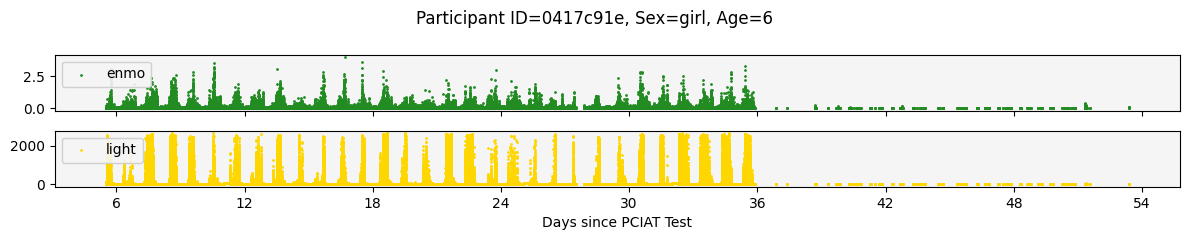

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Load the initial actigraphy data for verification
actigraphy_sample = pl.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet')
print(actigraphy_sample)

# Define the function to analyze and visualize actigraphy data
def analyze_actigraphy(participant_id, one_week_only=False, minimal_features=False):
    # Load the specific participant's actigraphy data
    actigraphy_data = pl.read_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={participant_id}/part-0.parquet')
    
    # Calculate the "day" based on relative PCIAT test date and time of day
    days_since_test = actigraphy_data.get_column('relative_date_PCIAT') + actigraphy_data.get_column('time_of_day') / 86400e9
    
    # Retrieve age and sex information for participant
    participant_info = train_data.filter(pl.col('id') == participant_id)
    age = participant_info.get_column('Basic_Demos-Age').item()
    sex = 'boy' if participant_info.get_column('Basic_Demos-Sex').item() == 0 else 'girl'
    
    # Add computed features: time differences and acceleration norm
    actigraphy_data = (
        actigraphy_data
        .with_columns(
            (days_since_test.diff() * 86400).alias('time_diff_seconds'),
            (np.sqrt(np.square(pl.col('X')) + np.square(pl.col('Y')) + np.square(pl.col('Z')))).alias('accel_norm')
        )
    )
    
    # Apply data mask based on whether only one week of data is desired
    if one_week_only:
        start_day = np.ceil(days_since_test.min())
        mask = (start_day <= days_since_test.to_numpy()) & (days_since_test.to_numpy() <= start_day + 7)
        mask &= ~actigraphy_data.get_column('non-wear_flag').cast(bool).to_numpy()
    else:
        mask = np.ones(len(days_since_test), dtype=bool)  # Use all data if one_week_only is False

    # Select features to plot based on the minimal_features flag
    if minimal_features:
        feature_list = [
            ('enmo', 'forestgreen'),
            ('light', 'gold'),
        ]
    else:
        feature_list = [
            ('X', 'mediumslateblue'),
            ('Y', 'deepskyblue'),
            ('Z', 'dodgerblue'),
            ('enmo', 'forestgreen'),
            ('anglez', 'lightblue'),
            ('light', 'gold'),
            ('non-wear_flag', 'darkorange')
        ]

    # Plot each selected feature over time
    fig, axes = plt.subplots(len(feature_list), 1, sharex=True, figsize=(12, len(feature_list) * 1.2))
    for ax, (feature, color) in zip(axes, feature_list):
        ax.set_facecolor('#f5f5f5')
        ax.scatter(days_since_test.to_numpy()[mask],
                   actigraphy_data.get_column(feature).to_numpy()[mask],
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#f5f5f5', framealpha=0.9)
        if feature == 'time_diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    
    # Set titles and labels
    fig.suptitle(f'Participant ID={participant_id}, Sex={sex}, Age={age}')
    axes[-1].set_xlabel('Days since PCIAT Test')
    axes[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

# Test the function with participant ID and settings
analyze_actigraphy('0417c91e', one_week_only=False, minimal_features=True)

# Set seed and define number of splits for cross-validation (if needed later)
import random
def seed_everything(seed):
    """Set the random seed for reproducibility.

    Args:
        seed (int): Seed value.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the random seed
seed_everything(2024)

SEED = 42
n_splits = 5


In [49]:
# Load data
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df



In [51]:
# Merge and Drop Columns
        
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")
test_ts.head()

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)   

100%|██████████| 2/2 [00:00<00:00, 12.04it/s]


In [52]:
# Select Relevant Features and Handle Missing Values
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

In [53]:
# Feature Extraction 

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)


In [54]:

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)



In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.base import clone
from scipy.optimize import minimize
from colorama import Fore, Style
from IPython.display import clear_output

def TrainML(model_class, test_data, sample):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    n_splits = 5  # Number of splits for StratifiedKFold
    SEED = 42  # Random seed for reproducibility
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    # Optimize Kappa Score
    KappaOptimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.49, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOptimizer.success, "Optimization did not converge."
    thresholds = KappaOptimizer.x
    
    oof_tuned = threshold_Rounder(oof_non_rounded, thresholds)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT}{tKappa:.3f}{Style.RESET_ALL}")

    # Compute Accuracy
    accuracy = accuracy_score(y, oof_rounded)
    print(f"Accuracy: {accuracy:.4f}")

    # Compute Confusion Matrix
    cm = confusion_matrix(y, oof_rounded)
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Weighted Averaging of Test Predictions
    fold_weights = [1.25, 1.0, 1.0, 1.0, 1.0]
    fold_weights = np.array(fold_weights) / np.sum(fold_weights)  # Normalize weights
    tpm = test_preds.dot(fold_weights)
    tpTuned = threshold_Rounder(tpm, thresholds)

    # Create submission DataFrame ensuring proper structure
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission


Training Folds: 100%|██████████| 5/5 [00:56<00:00, 11.34s/it]

Mean Train QWK --> 0.7595
Mean Validation QWK ---> 0.3926


Optimized QWK SCORE :: 0.456
Accuracy: 0.5687
Confusion Matrix:
[[1046  543    5    0]
 [ 230  485   15    0]
 [  70  283   25    0]
 [   0   23   11    0]]


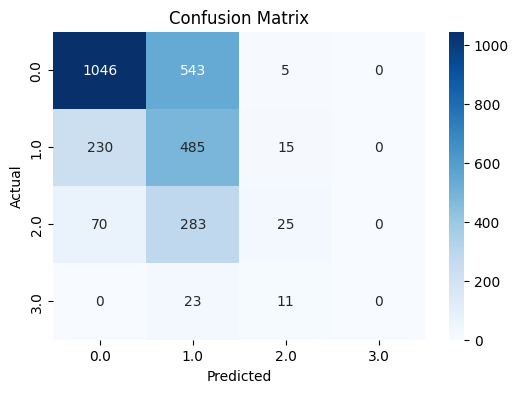

,id,sii
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0
5,5,1
6,6,0
7,7,0
8,8,1
9,9,0


In [95]:
# Parameters 

Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  
    'lambda_l2': 0.01  
}



XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1, 
    'reg_lambda': 5,  
    'random_state': SEED
}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 10  
}


Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)


voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
])
sample = pd.DataFrame({'id': test.index})  # If test dataset has an index

# Train the ensemble model
Submission1 = TrainML(voting_model, test,sample)

Submission1

In [94]:
# Function to encoder time data 
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        """AutoEncoder with customizable input and encoding dimensions.

        Args:
            input_dim (int): Dimension of the input features.
            encoding_dim (int): Dimension of the encoded representation.
        """
        super(AutoEncoder, self).__init__()

        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 3),
            nn.ReLU(),
            nn.Linear(encoding_dim * 3, encoding_dim * 2),
            nn.ReLU(),
            nn.Linear(encoding_dim * 2, encoding_dim),
            nn.ReLU()
        )

        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim * 2),
            nn.ReLU(),
            nn.Linear(input_dim * 2, input_dim * 3),
            nn.ReLU(),
            nn.Linear(input_dim * 3, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        """Forward pass for the AutoEncoder.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Reconstructed output tensor.
        """
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [58]:
def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    """Train an AutoEncoder on the provided DataFrame and return encoded features.

    Args:
        df (pd.DataFrame): Input DataFrame with features to encode.
        encoding_dim (int): Dimension of the encoded representation.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        pd.DataFrame: Encoded feature DataFrame.
    """
    # Normalize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    data_tensor = torch.FloatTensor(df_scaled)

    # Initialize AutoEncoder
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())

    # Training loop
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i: i + batch_size]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            reconstructed = autoencoder(batch)

            # Compute loss and backpropagate
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()

        # Log progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    # Encode the data
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()

    # Create DataFrame for encoded features
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])

    return df_encoded

In [59]:
# Load data
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

In [60]:
# Merge and Drop Columns# 
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

train_data = train_ts.drop('id', axis = 1)
test_data = test_ts.drop('id', axis = 1)

train_decodedData = perform_autoencoder(train_data, encoding_dim=60, epochs=100, batch_size=32)
test_decodedData = perform_autoencoder(test_data, encoding_dim=60, epochs=100, batch_size=32)

time_series_cols = train_decodedData.columns.tolist()
train_decodedData['id'] = train_ts['id']
test_decodedData['id'] = test_ts['id']

train = pd.merge(train, train_decodedData, how="left", on='id')
test = pd.merge(test, test_decodedData, how="left", on='id')

100%|██████████| 2/2 [00:00<00:00, 12.14it/s]


Epoch [10/100], Loss: 1.6710
Epoch [20/100], Loss: 1.5469
Epoch [30/100], Loss: 1.5154
Epoch [40/100], Loss: 1.4932
Epoch [50/100], Loss: 1.4964
Epoch [60/100], Loss: 1.4920
Epoch [70/100], Loss: 1.4309
Epoch [80/100], Loss: 1.4185
Epoch [90/100], Loss: 1.3667
Epoch [100/100], Loss: 1.3620
Epoch [10/100], Loss: 1.0070
Epoch [20/100], Loss: 0.5783
Epoch [30/100], Loss: 0.4271
Epoch [40/100], Loss: 0.4271
Epoch [50/100], Loss: 0.4271
Epoch [60/100], Loss: 0.4271
Epoch [70/100], Loss: 0.4271
Epoch [80/100], Loss: 0.4271
Epoch [90/100], Loss: 0.4271
Epoch [100/100], Loss: 0.4271


In [61]:
def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']
    return df

In [62]:
imputer = KNNImputer(n_neighbors=5)

In [63]:
numeric_cols = train.select_dtypes(include=['int32', 'int64', 'float64', 'int64']).columns
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]
        
train = train_imputed

train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)

In [64]:
train

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,id,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,BFP_BMI,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,ICW_TBW,BMI_PHR
0,5.0,0.0,51.0,16.877316,46.00,50.8,23.0,61.2,86.4,110.6,4.0,5.8,27.0,0.0,0.0,17.56,1.8,16.18,1.4,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.668550,16.87920,932.4980,1492.000,8.255980,41.58620,13.81770,3.061430,9.213770,1.0,24.43490,8.895360,38.91770,19.54130,32.69090,1.9120,2.2220,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,48.4,62.2,3.0,2,00008ff9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.386578,15.0,50.631947,0.545865,1.499679,0.332267,1.190475,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.747453,1458.200076
1,9.0,0.0,70.0,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,4.6,6.6,24.2,3.0,0.0,16.04,1.6,15.50,1.6,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.579490,14.03710,936.6560,1498.650,6.019930,42.02910,12.82540,1.211720,3.970850,1.0,21.03520,14.974000,39.44970,15.41070,27.05520,2.6260,2.3400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,64.0,0.0,0,000fd460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.320313,0.0,0.000000,0.282883,3.229888,0.305154,1.458119,3719.320478,5950.914352,20.362087,32.579348,0.321056,12.718037,0.588157,0.777492,982.491320
2,10.0,1.0,71.0,16.648696,56.50,75.6,24.8,65.0,94.0,117.0,5.0,7.0,33.0,20.0,1.0,10.20,1.0,14.70,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,2.6,3.431454,19.10500,1106.4030,1889.264,17.199762,60.10940,14.83936,4.265620,17.650582,2.6,28.81348,14.096188,56.67794,27.61536,46.01322,2.0938,2.1700,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,38.0,54.0,2.0,0,00105258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,166.486961,20.0,33.297392,0.923872,0.840729,0.241670,1.231775,19528.656877,33346.609152,14.634960,2

In [65]:
train = train.drop('id', axis=1)
test  = test .drop('id', axis=1)

In [66]:
#  Select Relevant Features and Handle Missing Values: 
featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'sii', 'BMI_Age', 'Internet_Hours_Age', 'BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight', 'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'BMI_PHR']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

#  Select Relevant Features and Handle Missing Values: 
featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age', 'Internet_Hours_Age', 'BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight', 'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'BMI_PHR']

featuresCols += time_series_cols
test = test[featuresCols]

In [67]:
train

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,BFP_BMI,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,ICW_TBW,BMI_PHR,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60
0,5.0,0.0,51.0,16.877316,46.00,50.8,23.0,61.2,86.4,110.6,4.0,5.8,27.0,0.0,0.0,17.56,1.8,16.18,1.4,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.668550,16.87920,932.4980,1492.000,8.255980,41.58620,13.81770,3.061430,9.213770,1.0,24.43490,8.895360,38.91770,19.54130,32.69090,1.9120,2.2220,48.4,62.2,3.0,2,84.386578,15.0,50.631947,0.545865,1.499679,0.332267,1.190475,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.747453,1458.200076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9.0,0.0,70.0,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,4.6,6.6,24.2,3.0,0.0,16.04,1.6,15.50,1.6,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.579490,14.03710,936.6560,1498.650,6.019930,42.02910,12.82540,1.211720,3.970850,1.0,21.03520,14.974000,39.44970,15.41070,27.05520,2.6260,2.3400,46.0,64.0,0.0,0,126.320313,0.0,0.000000,0.282883,3.229888,0.305154,1.458119,3719.320478,5950.914352,20.362087,32.579348,0.321056,12.718037,0.588157,0.777492,982.491320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,1.0,71.0,16.648696,56.50,75.6,24.8,65.0,94.0,117.0,5.0,7.0,33.0,20.0,1.0,10.20,1.0,14.70,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,2.6,3.431454,19.10500,1106.4030,1889.264,17.199762,60.10940,14.83936,4.265620,17.650582,2.6,28.81348,14.096188,56.67794,27.61536,46.01322,2.0938,2.1700,38.0,54.0,2.0,0,166.486961,20.0,33.297392,0.923872,0.840729,0.241670,1.231775,19528.656877,33346.609152,14.634960,24.990265,0.488767,6.473938,0.608640,0.626200,1564.977430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.0,0.0,71.0,18.292347,56.00,81.6,25.4,60.0,97.0,117.0,6.0,9.0,37.0,18.0,1.0,14.50,1.6,16.92,2.2,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3.0,3.841910,18.29430,1131.4300,1923.440,15.592500,62.77570,14.07400,4.220330,18.824300,2.0,30.40410,16.779000,58.93380,26.47980,45.99660,1.7980,2.4510,31.0,45.0,0.0,1,164.631122,0.0,0.000000,1.028971,0.747651,0.224196,1.281264,21298.377749,36207.411592,13.865564,23.571569,0.472854,6.274343,0.563684,0.661008,1774.357653,3.988518,4.797661,0.000000,1.723124,0.000000,1.200257,0.863303,6.660570,3.503572,4.610542,2.

In [68]:
test.shape

(20, 124)

In [69]:


# for col in cat_c:
#     mapping = create_mapping(col, train)
#     mappingTe = create_mapping(col, test)
    
#     train[col] = train[col].replace(mapping).astype(int)
#     test[col] = test[col].replace(mappingTe).astype(int)

if np.any(np.isinf(train)):
    train = train.replace([np.inf, -np.inf], np.nan)

In [70]:
test.shape

(20, 124)

In [77]:
def TrainML(model_class, test_data, sample):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    n_splits = 5  # Define number of splits
    SEED = 42  # Set random seed for reproducibility
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    # Optimize Kappa Score
    KappaOptimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOptimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOptimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)
    print(f" || Optimized QWK SCORE :: {tKappa:.3f}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOptimizer.x)
    
    # Compute Accuracy
    accuracy = accuracy_score(y, oof_rounded)
    print(f"Accuracy: {accuracy:.4f}")

    # Compute Confusion Matrix
    cm = confusion_matrix(y, oof_rounded)
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Create submission DataFrame ensuring 'sample' structure
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission

In [78]:
class TabNetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        """Wrapper for TabNetRegressor with sklearn compatibility."""
        self.model = TabNetRegressor(**kwargs)
        self.kwargs = kwargs
        self.imputer = SimpleImputer(strategy='median')
        self.best_model_path = 'best_tabnet_model.pt'

    def fit(self, X, y):
        """Fit the TabNet model to the provided data.

        Args:
            X (pd.DataFrame or np.ndarray): Features.
            y (pd.Series or np.ndarray): Target values.

        Returns:
            self: Fitted instance.
        """
        # Handle missing values
        X_imputed = self.imputer.fit_transform(X)
        y = y.values if hasattr(y, 'values') else y

        # Create train-validation split
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_imputed, y, test_size=0.2, random_state=42
        )

        # Train the TabNet model
        self.model.fit(
            X_train=X_train,
            y_train=y_train.reshape(-1, 1),
            eval_set=[(X_valid, y_valid.reshape(-1, 1))],
            eval_name=['valid'],
            eval_metric=['mse'],
            max_epochs=200,
            patience=20,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            callbacks=[
                TabNetPretrainedModelCheckpoint(
                    filepath=self.best_model_path,
                    monitor='valid_mse',
                    mode='min',
                    save_best_only=True,
                    verbose=True
                )
            ]
        )

        # Load the best model and remove temporary file
        if os.path.exists(self.best_model_path):
            self.model.load_model(self.best_model_path)
            os.remove(self.best_model_path)

        return self

    def predict(self, X):
        """Make predictions using the TabNet model.

        Args:
            X (pd.DataFrame or np.ndarray): Features for prediction.

        Returns:
            np.ndarray: Predicted values.
        """
        X_imputed = self.imputer.transform(X)
        return self.model.predict(X_imputed).flatten()

    def __deepcopy__(self, memo):
        """Support deepcopy for sklearn compatibility."""
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for key, value in self.__dict__.items():
            setattr(result, key, deepcopy(value, memo))
        return result

class TabNetPretrainedModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1):
        """Callback to save the best model during training.

        Args:
            filepath (str): Path to save the model.
            monitor (str): Metric to monitor.
            mode (str): 'min' or 'max' to track the metric.
            save_best_only (bool): Save only the best model.
            verbose (int): Verbosity level.
        """
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = float('inf') if mode == 'min' else -float('inf')

    def on_train_begin(self, logs=None):
        """Initialize the callback with the trainer model."""
        self.model = self.trainer

    def on_epoch_end(self, epoch, logs=None):
        """Check and save the model if the monitored metric improves."""
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return

        if (self.mode == 'min' and current < self.best) or (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'\nEpoch {epoch}: {self.monitor} improved from {self.best:.4f} to {current:.4f}')
            self.best = current
            if self.save_best_only:
                self.model.save_model(self.filepath)

# TabNet hyperparameters
TabNet_Params = {
    'n_d': 64,              
    'n_a': 64,              
    'n_steps': 5,           
    'gamma': 1.5,           
    'n_independent': 2,     
    'n_shared': 2,          
    'lambda_sparse': 1e-4, 
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
    'mask_type': 'entmax',
    'scheduler_params': dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
    'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'verbose': 1,
    'device_name': 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [79]:
SEED = 42
n_splits = 5

In [80]:
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  
    'lambda_l2': 0.01  
}



XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1, 
    'reg_lambda': 5,  
    'random_state': SEED, 
    'tree_method': 'gpu_hist'
}


CatBoost_Params = {
    'learning_rate': 0.046,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 10, 
    'task_type': 'GPU'

}

In [81]:
Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)
TabNet_Model = TabNetWrapper(**TabNet_Params)

Training Folds: 100%|██████████| 5/5 [01:20<00:00, 16.12s/it]


Mean Train QWK --> 0.7216
Mean Validation QWK ---> 0.4617
 || Optimized QWK SCORE :: 0.522
Accuracy: 0.6460
Confusion Matrix:
[[1488  687    3    0]
 [ 257 1049    5    0]
 [  55  361   21    0]
 [   1   27    6    0]]


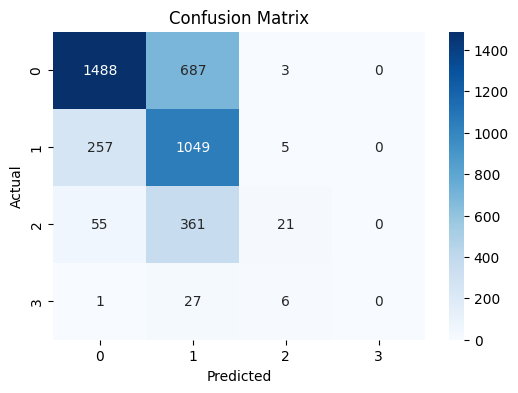

,id,sii
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1
5,5,1
6,6,1
7,7,0
8,8,1
9,9,1


In [83]:
voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model),
    ('tabnet', TabNet_Model)
],weights=[4.0,4.0,5.0,4.0])
sample = pd.DataFrame({'id': test.index})  # If test dataset has an index

Submission2 = TrainML(voting_model, test,sample)

Submission2

In [84]:
# Load data
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

In [85]:
# Merge and Drop Columns# 
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)  

100%|██████████| 2/2 [00:00<00:00, 11.23it/s]


In [86]:
# Select Relevant Features and Handle Missing Values
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

In [87]:
def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.base import clone
from scipy.optimize import minimize
from IPython.display import clear_output

def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    n_splits = 5  # Define number of splits
    SEED = 42  # Set random seed for reproducibility
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")
    
    # Optimize Kappa Score
    KappaOptimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOptimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOptimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)
    print(f" || Optimized QWK SCORE :: {tKappa:.3f}")

    tpm = test_preds.mean(axis=1)
    tp_rounded = threshold_Rounder(tpm, KappaOptimizer.x)
    
    # Compute Accuracy
    accuracy = accuracy_score(y, oof_rounded)
    print(f"Accuracy: {accuracy:.4f}")

    # Compute Confusion Matrix
    cm = confusion_matrix(y, oof_rounded)
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return tp_rounded


In [89]:
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  
    'lambda_l2': 0.01  
}



XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1, 
    'reg_lambda': 5,  
    'random_state': SEED
}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 10  
}



Training Folds: 100%|██████████| 5/5 [02:14<00:00, 26.86s/it]

Mean Train QWK --> 0.9175
Mean Validation QWK ---> 0.3803


 || Optimized QWK SCORE :: 0.450
Accuracy: 0.5614
Confusion Matrix:
[[1025  558   11    0]
 [ 230  483   17    0]
 [  68  282   28    0]
 [   0   25    9    0]]


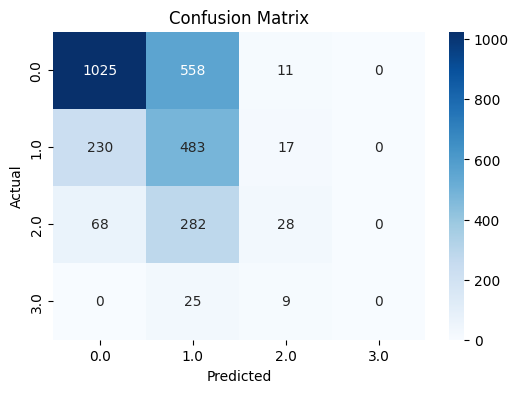

In [90]:
# Ensemble Model
imputer = SimpleImputer(strategy='median')

ensemble = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(random_state=SEED))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(random_state=SEED))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(random_state=SEED, silent=True))])),
    ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(random_state=SEED))])),
    ('gb', Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(random_state=SEED))]))
    
])

Submission3 = TrainML(ensemble, test)

In [91]:
Submission3 = pd.DataFrame({
    'id': sample['id'],
    'sii': Submission3
})

Submission3

,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,2
9,0083e397,0


In [ ]:
sub1 = Submission1
sub2 = Submission2
sub3 = Submission3

sub1 = sub1.sort_values(by='id').reset_index(drop=True)
sub2 = sub2.sort_values(by='id').reset_index(drop=True)
sub3 = sub3.sort_values(by='id').reset_index(drop=True)

combined = pd.DataFrame({
    'id': sub1['id'],
    'sii_1': sub1['sii'],
    'sii_2': sub2['sii'],
    'sii_3': sub3['sii']
})

def majority_vote(row):
    return row.mode()[0] if len(row.mode()) == 1 else row.mean().round().astype(int)

combined['final_sii'] = combined[['sii_1', 'sii_2', 'sii_3']].apply(majority_vote, axis=1)

final_submission = combined[['id', 'final_sii']].rename(columns={'final_sii': 'sii'})
final_submission.to_csv('submission.csv', index=False)